In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install sentence_transformers

     |████████████████████████████████| 79 kB 6.7 MB/s 
     |████████████████████████████████| 3.8 MB 40.6 MB/s 
     |████████████████████████████████| 1.2 MB 54.3 MB/s 
     |████████████████████████████████| 77 kB 6.5 MB/s 
     |████████████████████████████████| 895 kB 43.8 MB/s 
     |████████████████████████████████| 596 kB 62.6 MB/s 
     |████████████████████████████████| 6.5 MB 21.9 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=b5ae4bfc7bd5b4e01b76e294ba74d9531a2409a13c2a43c8db05469f1522ba0e
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import spacy
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset, Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.metrics import f1_score
#from sklearn.metrics import classification_report

In [4]:
#Reading csv file
train = pd.read_csv("/content/drive/MyDrive/DL_DialogDataset/train.csv")
test = pd.read_csv("/content/drive/MyDrive/DL_DialogDataset/test.csv")
train

,utterance,act
0,"Say , Jim , how about going for a few beers af...",3
1,You know that is tempting but is really not g...,4
2,What do you mean ? It will help us to relax .,2
3,Do you really think so ? I don't . It will ju...,2
4,I guess you are right.But what shall we do ? ...,2
...,...,...
5085,Tom and Helen got married at last .,1
5086,How did you know that ? I heart Tom ’ s fathe...,2
5087,I was invited to attend their wedding .,1
5088,It ’ s great . Although his father didn ’ t a...,1


In [5]:
Xtrain = train.utterance
ytrain = train.act - 1 
Xtest = test.utterance
ytest = test.act - 1
  

In [6]:
Xtrain

0       Say , Jim , how about going for a few beers af...
1        You know that is tempting but is really not g...
2          What do you mean ? It will help us to relax . 
3        Do you really think so ? I don't . It will ju...
4        I guess you are right.But what shall we do ? ...
                              ...                        
5085                 Tom and Helen got married at last . 
5086     How did you know that ? I heart Tom ’ s fathe...
5087             I was invited to attend their wedding . 
5088     It ’ s great . Although his father didn ’ t a...
5089                                How moving love is . 
Name: utterance, Length: 5090, dtype: object

In [ ]:
np.random.seed(0)
torch.manual_seed(0)

## Data Visualization

In [7]:
!pip install wordcloud

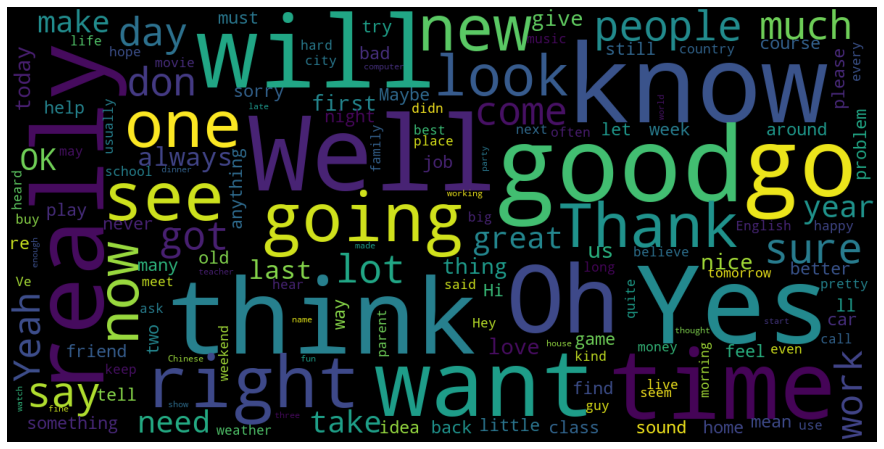

In [8]:
from wordcloud import WordCloud
# Display the world cloud
data = ' '.join(text for text in train['utterance'])
world_cloud = WordCloud(background_color='black',max_words=150,max_font_size=50,scale=3,random_state=1, collocations=False).generate(data)
plt.figure(figsize = (100,8))
plt.axis('off')
plt.imshow(world_cloud)

In [ ]:
unique, counts = np.unique(ytrain, return_counts=True)
plt.bar(unique, counts)
unique, counts = np.unique(ytest, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

## Preprocessing

In [9]:
!pip install contractions 

     |████████████████████████████████| 287 kB 22.7 MB/s 
     |████████████████████████████████| 106 kB 62.8 MB/s 


In [10]:
# Xtrain2 = []
# ytrain2 = []
# Xtest2 = []
# ytest2 = []
# for i in tqdm(range(0, len(Xtrain))):
#     newStr = ""
#     # Xtrain2.append( Xtrain[i-4] + ' '+Xtrain[i-3] + ' '+Xtrain[i-2] + ' '+Xtrain[i-1] + ' ' + Xtrain[i])
#     # Xtrain2.append(Xtrain[i-2] + ' '+Xtrain[i-1] + ' ' + Xtrain[i])
#     # Xtrain2.append(Xtrain[i-1] + ' ' + Xtrain[i])
#     Xtrain2.append(Xtrain[i])
#     ytrain2.append(ytrain[i])
# # for i in tqdm(range(1, len(Xtest))):
# #     Xtest2.append(Xtest[i-1] + ' ' + Xtest[i])
# #     ytest2.append(ytest[i])

# max_seq_len = len(max(Xtrain2, key=len))

In [11]:

def lowerCase(df):
  for i in range(len(df)):
    df[i] = df[i].lower()
  return df


In [12]:
import contractions

def contractionExpand(df):
  for i in range(len(df)):
    df[i] = contractions.fix(df[i])
  return df
  # return contractions.fix(text)


In [13]:
import nltk
nltk.download('punkt')

def tokenize(df):
  for i in range(len(df)):
    df[i] = nltk.word_tokenize(df[i])
  return df
 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [14]:
Xtrain

0       Say , Jim , how about going for a few beers af...
1        You know that is tempting but is really not g...
2          What do you mean ? It will help us to relax . 
3        Do you really think so ? I don't . It will ju...
4        I guess you are right.But what shall we do ? ...
                              ...                        
5085                 Tom and Helen got married at last . 
5086     How did you know that ? I heart Tom ’ s fathe...
5087             I was invited to attend their wedding . 
5088     It ’ s great . Although his father didn ’ t a...
5089                                How moving love is . 
Name: utterance, Length: 5090, dtype: object

In [15]:
Xtest

0                 I'm better now . Want to play again ? 
1              I'll let you break the balls this time . 
2          Let's get all the balls out of the pockets . 
3       OK . How much do you want to bet on this game ? 
4       You are crazy . Gambling is against my princi...
                             ...                        
717     Yeah , I got to eat as much pizza as I could ...
718                             Did you like the play ? 
719     Not really . It's a dull one , and the produc...
720     You're absolutely right . The acting could be...
721     To be fair , though , both the costumes and s...
Name: utterance, Length: 722, dtype: object

In [16]:
def preprocessing(x):
  x = lowerCase(x)
  x = contractionExpand(x)
  x = tokenize(x)
  return x

Xtrain = preprocessing(Xtrain)
Xtest = preprocessing(Xtest)





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
# max_seq_len = len(max(Xtrain, key=len))
# max_seq_len = len(max(Xtrain2, key=len))

### Sentence Embedding for each utterance: Using Bert sentence transformer

In [18]:
Xtrain = [[' '.join(i)] for i in Xtrain]
Xtrain = [i[0] for i in Xtrain]
Xtest = [[' '.join(i)] for i in Xtest]
Xtest = [i[0] for i in Xtest]

In [19]:
sbert_model = SentenceTransformer('all-mpnet-base-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [20]:
train_sentence_embeddings = sbert_model.encode(Xtrain)
test_sentence_embeddings = sbert_model.encode(Xtest)

In [21]:
train_sentence_embeddings.shape, test_sentence_embeddings.shape

((5090, 768), (722, 768))

In [22]:
test_sentence_embeddings = np.array(test_sentence_embeddings)

In [23]:
# X = 5  #x-1 prev utterances
def prep_data(X):
  Xtrain_context = np.zeros((len(train_sentence_embeddings)-X+1,X,train_sentence_embeddings.shape[1]))

  for i in range(len(train_sentence_embeddings)-X-1):
    k = 0
    for j in range(i,i+X):
      Xtrain_context[i][k] = train_sentence_embeddings[j]
      # Xtrain_context[i][k] = Xtrain_context[i][k].astype('int')
      # Xtrain_context[i][k] = [int(l) for l in Xtrain_context[i][k]]
      k+=1

  Xtest_context = np.zeros((len(test_sentence_embeddings)-X+1,X,test_sentence_embeddings.shape[1]))

  for i in range(len(test_sentence_embeddings)-X-1):
    k = 0
    for j in range(i,i+X):
      Xtest_context[i][k] = test_sentence_embeddings[j]
      # Xtrain_context[i][k] = Xtrain_context[i][k].astype('int')
      # Xtrain_context[i][k] = [int(l) for l in Xtrain_context[i][k]]
      k+=1

  # Xtrain_context = Xtrain_context.astype('int')
  ytrain_context = np.array(ytrain)
  ytrain_context = ytrain_context[X-1:]
  train_data = TensorDataset(torch.from_numpy(Xtrain_context), torch.from_numpy(ytrain_context))
  trainDataLoader = DataLoader(train_data,batch_size=32)
  ytest_context = np.array(ytest)
  ytest_context = ytest_context[X-1:]
  test_data = TensorDataset(torch.from_numpy(Xtest_context), torch.from_numpy(ytest_context))
  testDataLoader = DataLoader(test_data, batch_size=32)
  return trainDataLoader,testDataLoader, ytest_context




In [24]:
test_sentence_embeddings = np.array(test_sentence_embeddings)
# Xtest_id= np.vstack(Xtest_id).astype('int')
ytest = np.array(ytest)
test_data = TensorDataset(torch.from_numpy(test_sentence_embeddings), torch.from_numpy(ytest))

In [25]:
testDataLoader = DataLoader(test_data, batch_size=32)

In [26]:
class LSTMClass(nn.Module):
    def __init__(self,embedding_dim,hidden_size,num_layers,drop_prob):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding_dim = embedding_dim
        # print(embedding_dim)
        self.lstm = nn.LSTM(input_size=self.embedding_dim,hidden_size=self.hidden_size,num_layers=self.num_layers,batch_first=True,bidirectional=False)
        self.dropout = nn.Dropout(drop_prob)
        self.linear = nn.Linear(hidden_size, 4)
        # self.softmax = nn.Softmax()
        

    def forward(self, x):
      # print(x.shape)
      hnot = torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
      cnot = torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
      out,_ = self.lstm(x,(hnot,cnot))
      out = out[:,-1,:]
      # print("lstm",out.shape)
      out = self.dropout(out)
      out = self.linear(out)
      # print("lin",out.shape)
      # out = self.softmax(out)
      return out

In [27]:
lstm = LSTMClass(train_sentence_embeddings.shape[1],8,1,0.5).to(device)
criterion = nn.CrossEntropyLoss()
# criterion = nn.L1Loss()
optimizer = optim.Adam(lstm.parameters(), lr=0.01)

In [28]:
def lossVsEpochPlot(Loss,color,label):
    """
    Plot the loss vs epoch plot
    trainLoss: train loss
    validLoss: test loss
    """
    plt.plot(Loss, color=color)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel(label+" Loss")
    plt.title(label+ " Loss vs Epochs Plot")
#     plt.savefig("Plots/Ques2/part1/{}_lossVsEpochs.png".format(funtion))
    plt.show()


def accVsEpochPlot(trainAcc, testAcc):
    """
    Plot the accuracy vs epoch plot
    trainAcc: train accuracy
    validAcc: test accuracy
    """
    plt.plot(trainAcc, label="Train Accuracy", color="blue")
    plt.plot(testAcc, label="Test Accuracy", color="red")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epochs for ")
#     plt.savefig("Plots/Ques2/part1/{}_accVsEpochs.png".format(funtion))
    plt.show()

In [38]:
def AccReport(dataloader,flag):
  with torch.no_grad():
      nCorrect = 0
      nSamples = 0
      nClassCorrect = [0 for i in range(4)]
      nClassTotal = [0 for i in range(4)]
      yPred = []
     
          
      for i,data in tqdm(enumerate(dataloader)):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs = inputs.to(device)
          # print("l",labels.shape)
          # print(labels)
          labels = labels.reshape((-1,)).to(device)
          # if(flag):
          #   inputs = torch.unsqueeze(inputs,1)
          # print("l",labels.shape)
          # print(labels)
          
          outputs = lstm(inputs.float())
          loss = criterion(outputs, labels)
          # outputs = torch.squeeze(outputs)
          # outputs = outputs.reshape((-1, 1))
          # print(outputs.shape)
          _, predictions = torch.max(outputs,1)
          # print(predictions)
          # print("l",labels)
          nSamples += labels.shape[0]
          # nCorrect += (predictions == labels).sum().item()
          for i in range(len(predictions)):
            if predictions[i] == labels[i]:
              nCorrect += 1
            yPred.append(predictions[i])
           

            



      
      acc = 100.0 * nCorrect / nSamples
      if(flag):
        print(f'Accuracy on test: {acc:.2f}')
      else:
        print(f'Accuracy on train: {acc:.2f}')
      return acc,yPred

    

In [41]:
def training(X):
  trainDataLoader,testDataLoader,ytest = prep_data(X)
  totalSteps = len(trainDataLoader)
  numEpochs = 5
  trainLossAll = []
  trainAccAll = []
  valLossAll = []
  valAccAll = []
  # X = 2  # X previous utterances for t th utterance


  for epoch in range(numEpochs):  # loop over the dataset multiple times

      running_loss = 0.0
      trainLoss = 0
      
      for i, data in tqdm(enumerate(trainDataLoader)):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs = inputs.to(device)
          # print("l",labels.shape)
          # print(labels)
          labels = labels.reshape((-1,)).to(device)
          # print("l",labels.shape)
          # print(labels)
          # inputs = torch.squeeze(inputs,0)
          # print(inputs.shape)
          # print(inputs)
          # print(inputs.float().shape)
          outputs = lstm(inputs.float())
          
            
          # outputs = torch.squeeze(outputs)
          # outputs = outputs.reshape((-1, 1))
          # print(outputs.shape)
          loss = criterion(outputs, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          trainLoss += loss.item()*inputs.size(0)
      
          lstm.eval()
          validLoss = 0
          for data, target in testDataLoader:
              data, target = data.to(device), target.to(device)
              # data = torch.unsqueeze(data,1)
              # print(data.shape)
              output = lstm(data.float())
              # print(target)
              loss = criterion(output, target)
              validLoss += loss.item()*data.size(0)
          
    

      
          if (i+1) % 10 == 0:
              print(f'Epoch {epoch + 1} / {numEpochs}, Step {i+1} / {totalSteps}, Loss: {loss.item():.4f}')
              # print(outputs)

      trainLoss = trainLoss/len(trainDataLoader.dataset)
      validLoss = validLoss/len(testDataLoader.dataset)
          
      trainAcc,f1Train = AccReport(trainDataLoader,False)
      trainLossAll.append(trainLoss)
      trainAccAll.append(trainAcc)
      valAcc,f1Val = AccReport(testDataLoader,True)
      valLossAll.append(validLoss)
      valAccAll.append(valAcc)


  print('Finished Training')
  return trainDataLoader,testDataLoader,trainLossAll,trainAccAll,valLossAll,valAccAll,ytest

In [42]:
X_acc = []
X_f1 = []

In [43]:
def finalReport(ytest,trainDataLoader,testDataLoader,trainLossAll,valLossAll,trainAccAll, valAccAll):
  lossVsEpochPlot(trainLossAll, "blue","Training")
  lossVsEpochPlot(valLossAll, "red","Validation")
  trainAcc,yPred = AccReport(trainDataLoader,False)
  testAcc,yPred = AccReport(testDataLoader,True)
  accVsEpochPlot(trainAccAll, valAccAll)
  f1 = f1_score(ytest, yPred, average='weighted')
  print(f'fl score on test: {f1:.2f}')
  print(classification_report(ytest, yPred)) 
  return testAcc,f1



## X = 0

In [ ]:
lstm = LSTMClass(train_sentence_embeddings.shape[1],8,1,0.5).to(device)
criterion = nn.CrossEntropyLoss()
# criterion = nn.L1Loss()
optimizer = optim.Adam(lstm.parameters(), lr=0.01)
trainDataLoader,testDataLoader,trainLossAll,trainAccAll,valLossAll,valAccAll,ytest_context = training(1)

18it [00:00, 51.82it/s]

Epoch 1 / 5, Step 10 / 160, Loss: 1.2153
Epoch 1 / 5, Step 20 / 160, Loss: 1.0589


36it [00:00, 51.76it/s]

Epoch 1 / 5, Step 30 / 160, Loss: 0.9930
Epoch 1 / 5, Step 40 / 160, Loss: 0.9073


60it [00:01, 53.67it/s]

Epoch 1 / 5, Step 50 / 160, Loss: 0.7949
Epoch 1 / 5, Step 60 / 160, Loss: 0.6898


78it [00:01, 52.92it/s]

Epoch 1 / 5, Step 70 / 160, Loss: 0.6273
Epoch 1 / 5, Step 80 / 160, Loss: 0.5758


96it [00:01, 51.91it/s]

Epoch 1 / 5, Step 90 / 160, Loss: 0.5734
Epoch 1 / 5, Step 100 / 160, Loss: 0.5639


119it [00:02, 48.63it/s]

Epoch 1 / 5, Step 110 / 160, Loss: 0.5443


130it [00:02, 49.35it/s]

Epoch 1 / 5, Step 120 / 160, Loss: 0.5870
Epoch 1 / 5, Step 130 / 160, Loss: 0.5178


147it [00:02, 49.48it/s]

Epoch 1 / 5, Step 140 / 160, Loss: 0.5191
Epoch 1 / 5, Step 150 / 160, Loss: 0.5340


160it [00:03, 50.84it/s]


Epoch 1 / 5, Step 160 / 160, Loss: 0.5092


160it [00:00, 861.03it/s]


Accuracy on train: 76.23


23it [00:00, 718.46it/s]


Accuracy on test: 70.50


6it [00:00, 55.63it/s]

Epoch 2 / 5, Step 10 / 160, Loss: 0.4940


18it [00:00, 52.95it/s]

Epoch 2 / 5, Step 20 / 160, Loss: 0.4849


30it [00:00, 53.52it/s]

Epoch 2 / 5, Step 30 / 160, Loss: 0.4434


36it [00:00, 53.07it/s]

Epoch 2 / 5, Step 40 / 160, Loss: 0.4140


59it [00:01, 48.23it/s]

Epoch 2 / 5, Step 50 / 160, Loss: 0.4143


70it [00:01, 49.54it/s]

Epoch 2 / 5, Step 60 / 160, Loss: 0.4085
Epoch 2 / 5, Step 70 / 160, Loss: 0.4058


87it [00:01, 48.94it/s]

Epoch 2 / 5, Step 80 / 160, Loss: 0.4007


97it [00:01, 48.10it/s]

Epoch 2 / 5, Step 90 / 160, Loss: 0.4180
Epoch 2 / 5, Step 100 / 160, Loss: 0.4275


121it [00:02, 52.76it/s]

Epoch 2 / 5, Step 110 / 160, Loss: 0.4231
Epoch 2 / 5, Step 120 / 160, Loss: 0.4666


139it [00:02, 53.88it/s]

Epoch 2 / 5, Step 130 / 160, Loss: 0.4297
Epoch 2 / 5, Step 140 / 160, Loss: 0.4304


160it [00:03, 51.15it/s]


Epoch 2 / 5, Step 150 / 160, Loss: 0.4486
Epoch 2 / 5, Step 160 / 160, Loss: 0.4125


160it [00:00, 1013.79it/s]


Accuracy on train: 80.00


23it [00:00, 870.23it/s]


Accuracy on test: 72.58


6it [00:00, 54.45it/s]

Epoch 3 / 5, Step 10 / 160, Loss: 0.4095


18it [00:00, 53.37it/s]

Epoch 3 / 5, Step 20 / 160, Loss: 0.4104


30it [00:00, 52.70it/s]

Epoch 3 / 5, Step 30 / 160, Loss: 0.3818


36it [00:00, 50.82it/s]

Epoch 3 / 5, Step 40 / 160, Loss: 0.3602


48it [00:00, 52.49it/s]

Epoch 3 / 5, Step 50 / 160, Loss: 0.3651


60it [00:01, 54.22it/s]

Epoch 3 / 5, Step 60 / 160, Loss: 0.3647


66it [00:01, 53.64it/s]

Epoch 3 / 5, Step 70 / 160, Loss: 0.3661


78it [00:01, 54.29it/s]

Epoch 3 / 5, Step 80 / 160, Loss: 0.3648


96it [00:01, 51.03it/s]

Epoch 3 / 5, Step 90 / 160, Loss: 0.3853
Epoch 3 / 5, Step 100 / 160, Loss: 0.3920


120it [00:02, 52.78it/s]

Epoch 3 / 5, Step 110 / 160, Loss: 0.3867
Epoch 3 / 5, Step 120 / 160, Loss: 0.4327


138it [00:02, 52.87it/s]

Epoch 3 / 5, Step 130 / 160, Loss: 0.4089
Epoch 3 / 5, Step 140 / 160, Loss: 0.4036


160it [00:03, 52.38it/s]


Epoch 3 / 5, Step 150 / 160, Loss: 0.4141
Epoch 3 / 5, Step 160 / 160, Loss: 0.3766


160it [00:00, 1008.57it/s]


Accuracy on train: 82.42


23it [00:00, 802.66it/s]


Accuracy on test: 72.85


18it [00:00, 52.41it/s]

Epoch 4 / 5, Step 10 / 160, Loss: 0.3776
Epoch 4 / 5, Step 20 / 160, Loss: 0.3791


36it [00:00, 52.82it/s]

Epoch 4 / 5, Step 30 / 160, Loss: 0.3592
Epoch 4 / 5, Step 40 / 160, Loss: 0.3379


60it [00:01, 54.51it/s]

Epoch 4 / 5, Step 50 / 160, Loss: 0.3438
Epoch 4 / 5, Step 60 / 160, Loss: 0.3496


78it [00:01, 53.11it/s]

Epoch 4 / 5, Step 70 / 160, Loss: 0.3537
Epoch 4 / 5, Step 80 / 160, Loss: 0.3527


96it [00:01, 54.61it/s]

Epoch 4 / 5, Step 90 / 160, Loss: 0.3715
Epoch 4 / 5, Step 100 / 160, Loss: 0.3767


120it [00:02, 54.23it/s]

Epoch 4 / 5, Step 110 / 160, Loss: 0.3671
Epoch 4 / 5, Step 120 / 160, Loss: 0.4210


138it [00:02, 51.70it/s]

Epoch 4 / 5, Step 130 / 160, Loss: 0.4037


150it [00:02, 53.19it/s]

Epoch 4 / 5, Step 140 / 160, Loss: 0.3941
Epoch 4 / 5, Step 150 / 160, Loss: 0.3904


160it [00:03, 53.18it/s]


Epoch 4 / 5, Step 160 / 160, Loss: 0.3554


160it [00:00, 928.07it/s]


Accuracy on train: 84.58


23it [00:00, 692.48it/s]


Accuracy on test: 74.65


17it [00:00, 51.08it/s]

Epoch 5 / 5, Step 10 / 160, Loss: 0.3557
Epoch 5 / 5, Step 20 / 160, Loss: 0.3575


41it [00:00, 53.68it/s]

Epoch 5 / 5, Step 30 / 160, Loss: 0.3499
Epoch 5 / 5, Step 40 / 160, Loss: 0.3297


59it [00:01, 52.77it/s]

Epoch 5 / 5, Step 50 / 160, Loss: 0.3366
Epoch 5 / 5, Step 60 / 160, Loss: 0.3464


77it [00:01, 53.02it/s]

Epoch 5 / 5, Step 70 / 160, Loss: 0.3522
Epoch 5 / 5, Step 80 / 160, Loss: 0.3523


101it [00:01, 53.46it/s]

Epoch 5 / 5, Step 90 / 160, Loss: 0.3681
Epoch 5 / 5, Step 100 / 160, Loss: 0.3701


In [ ]:
Acc,f1 = finalReport(ytest_context,trainDataLoader,testDataLoader,trainLossAll,valLossAll,trainAccAll, valAccAll)
X_f1.append(f1)
X_acc.append(Acc)

## X = 1

In [ ]:
lstm = LSTMClass(train_sentence_embeddings.shape[1],8,1,0.5).to(device)
criterion = nn.CrossEntropyLoss()
# criterion = nn.L1Loss()
optimizer = optim.Adam(lstm.parameters(), lr=0.01)
trainDataLoader,testDataLoader,trainLossAll,trainAccAll,valLossAll,valAccAll,ytest_context = training(2)

In [ ]:
Acc,f1 = finalReport(ytest_context,trainDataLoader,testDataLoader,trainLossAll,valLossAll,trainAccAll, valAccAll)
X_f1.append(f1)
X_acc.append(Acc)

## X = 2

In [ ]:
lstm = LSTMClass(train_sentence_embeddings.shape[1],8,1,0.5).to(device)
criterion = nn.CrossEntropyLoss()
# criterion = nn.L1Loss()
optimizer = optim.Adam(lstm.parameters(), lr=0.01)
trainDataLoader,testDataLoader,trainLossAll,trainAccAll,valLossAll,valAccAll,ytest_context = training(3)

In [ ]:
Acc,f1 = finalReport(ytest_context,trainDataLoader,testDataLoader,trainLossAll,valLossAll,trainAccAll, valAccAll)
X_f1.append(f1)
X_acc.append(Acc)

## X = 3

In [ ]:
lstm = LSTMClass(train_sentence_embeddings.shape[1],8,1,0.5).to(device)
criterion = nn.CrossEntropyLoss()
# criterion = nn.L1Loss()
optimizer = optim.Adam(lstm.parameters(), lr=0.01)
trainDataLoader,testDataLoader,trainLossAll,trainAccAll,valLossAll,valAccAll,ytest_context = training(4)

In [ ]:
Acc,f1 = finalReport(ytest_context,trainDataLoader,testDataLoader,trainLossAll,valLossAll,trainAccAll, valAccAll)
X_f1.append(f1)
X_acc.append(Acc)

## X = 4

In [ ]:
lstm = LSTMClass(train_sentence_embeddings.shape[1],8,1,0.5).to(device)
criterion = nn.CrossEntropyLoss()
# criterion = nn.L1Loss()
optimizer = optim.Adam(lstm.parameters(), lr=0.01)
trainDataLoader,testDataLoader,trainLossAll,trainAccAll,valLossAll,valAccAll,ytest_context = training(5)

In [ ]:
Acc,f1 = finalReport(ytest_context,trainDataLoader,testDataLoader,trainLossAll,valLossAll,trainAccAll, valAccAll)
X_f1.append(f1)
X_acc.append(Acc)

In [ ]:
plt.plot(X_acc, color="blue")
print(len(X_acc))
plt.legend()
plt.xlabel("X")
plt.ylabel("Accuracy")
plt.title("Accuracy vs X ")
#     plt.savefig("Plots/Ques2/part1/{}_accVsEpochs.png".format(funtion))
plt.show()

In [ ]:
plt.plot(X_f1, label="X F1 Score", color="red")
plt.xlabel("X")
plt.ylabel("F1 Score")
plt.title("F1 Score vs X ")
plt.show()

Dataloader for taking only previous x utterances (Sliding window --> if x utterances to be considered send x+1 samples at a time (x+1 is window size)) 

### Sentence Embedding for each utterance: Using Glove and then pooling

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!ls -lat

In [ ]:
vocab,embeddings = [],[]
with open('glove.6B.50d.txt','rt') as fi:
    full_content = fi.read().strip().split('\n')
for i in range(len(full_content)):
    i_word = full_content[i].split(' ')[0]
    i_embeddings = [float(val) for val in full_content[i].split(' ')[1:]]
    vocab.append(i_word)
    embeddings.append(i_embeddings)

vocab_npa = np.array(vocab)
embs_npa = np.array(embeddings)




In [ ]:
#insert '<pad>' and '<unk>' tokens at start of vocab_npa.
vocab_npa = np.insert(vocab_npa, 0, '<pad>')
vocab_npa = np.insert(vocab_npa, 1, '<unk>')
print(vocab_npa[:10])

pad_emb_npa = np.zeros((1,embs_npa.shape[1]))   #embedding for '<pad>' token.
unk_emb_npa = np.mean(embs_npa,axis=0,keepdims=True)    #embedding for '<unk>' token.

#insert embeddings for pad and unk tokens at top of embs_npa.
embs_npa = np.vstack((pad_emb_npa,unk_emb_npa,embs_npa))
print(embs_npa.shape)

In [ ]:
max_seq_len = len(max(Xtrain, key=len))

In [ ]:
def convert_text_to_id(df,vocab,unk_token,pad_to_len,pad_token):
  word2idx = {term:idx for idx,term in enumerate(vocab)}
  idx2word = {idx:word for word,idx in word2idx.items()}

  for i in range(len(df)):
    deficit = pad_to_len - len(df[i])
    df[i].extend([pad_token]*deficit)
    for j in range(len(df[i])):
      if df[i][j] not in word2idx:
        df[i][j] = word2idx[unk_token]
      else:
        df[i][j] = word2idx[df[i][j]]
  return df


Xtrain_id = convert_text_to_id(Xtrain,vocab_npa,'<unk>',max_seq_len,'<pad>')

In [ ]:
Xtest_id = convert_text_to_id(Xtest,vocab_npa,'<unk>',max_seq_len,'<pad>')

In [ ]:
class LSTMGloveClass(nn.Module):
    def __init__(self,embs_nps,hidden_size,num_layers,drop_prob):
        super().__init__()
        self.vocab_size = embs_npa.shape[0]
        self.embedding_dim = embs_npa.shape[1]
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embs_npa).float(),freeze=True)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.pool = nn.AdaptiveAvgPool2d((1,self.embedding_dim))
        self.lstm = nn.LSTM(input_size=self.embedding_dim,hidden_size=self.hidden_size,num_layers=self.num_layers,batch_first=True,bidirectional=False)
        self.dropout = nn.Dropout(drop_prob)
        self.linear = nn.Linear(hidden_size, 4)
        # self.softmax = nn.Softmax()
        

    def forward(self, x):
      embed_out = self.embedding(x)
      # print("emb",embed_out.shape)
      sentence_embed_out = self.pool(embed_out)
      sentence_embed_out = torch.squeeze(sentence_embed_out,2)
      # print("Senemb",sentence_embed_out.shape)
      hnot = torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
      cnot = torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
      out,_ = self.lstm(sentence_embed_out,(hnot,cnot))
      out = out[:,-1,:]
      # print("lstm",out.shape)
      out = self.dropout(out)
      out = self.linear(out)
      # print("lin",out.shape)
      # out = self.softmax(out)
      return out

In [ ]:
totalSteps = len(trainDataLoader)
numEpochs = 10
trainLossAll = []
trainAccAll = []
valLossAll = []
valAccAll = []
X = 2  # X previous utterances for t th utterance


for epoch in range(numEpochs):  # loop over the dataset multiple times

    running_loss = 0.0
    trainLoss = 0
    
    for i, data in tqdm(enumerate(trainDataLoader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        # print("l",labels.shape)
        # print(labels)
        labels = labels.reshape((-1,)).to(device)
        # print("l",labels.shape)
        # print(labels)
        # inputs = torch.squeeze(inputs,0)
        # print(inputs.shape)
        # print(inputs)
        # print(inputs.float().shape)
        outputs = lstm(inputs.float())
        
          
        # outputs = torch.squeeze(outputs)
        # outputs = outputs.reshape((-1, 1))
        # print(outputs.shape)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        trainLoss += loss.item()*inputs.size(0)
    
        lstm.eval()
        validLoss = 0
        for data, target in testDataLoader:
            data, target = data.to(device), target.to(device)
            data = torch.unsqueeze(data,1)
            # print(data.shape)
            output = lstm(data)
            # print(target)
            loss = criterion(output, target)
            validLoss += loss.item()*data.size(0)
        
  

    
        if (i+1) % 10 == 0:
            print(f'Epoch {epoch + 1} / {numEpochs}, Step {i+1} / {totalSteps}, Loss: {loss.item():.4f}')
            # print(outputs)

    trainLoss = trainLoss/len(trainDataLoader.dataset)
    validLoss = validLoss/len(testDataLoader.dataset)
        
    trainAcc,f1Train = AccReport(trainDataLoader,False)
    trainLossAll.append(trainLoss)
    trainAccAll.append(trainAcc)
    valAcc,f1Val = AccReport(testDataLoader,True)
    valLossAll.append(validLoss)
    valAccAll.append(valAcc)


print('Finished Training')

In [ ]:
X_acc_glove = []
X_f1_glove = []

# X = 0

In [ ]:
Acc,f1 = finalReport(trainDataLoader,testDataLoader,trainLossAll,valLossAll)
X_f1_glove.append(f1)
X_acc_glove.append(Acc)

# X = 1

In [ ]:
Acc,f1 = finalReport(trainDataLoader,testDataLoader,trainLossAll,valLossAll)
X_f1_glove.append(f1)
X_acc_glove.append(Acc)

# X = 2

In [ ]:
Acc,f1 = finalReport(trainDataLoader,testDataLoader,trainLossAll,valLossAll)
X_f1_glove.append(f1)
X_acc_glove.append(Acc)

# X = 3

In [ ]:
Acc,f1 = finalReport(trainDataLoader,testDataLoader,trainLossAll,valLossAll)
X_f1_glove.append(f1)
X_acc_glove.append(Acc)

# X = 4

In [ ]:
Acc,f1 = finalReport(trainDataLoader,testDataLoader,trainLossAll,valLossAll)
X_f1_glove.append(f1)
X_acc_glove.append(Acc)